In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

path = "./Measurement Data"

# Project

## 1. Merge every trip dataset into a global one

In [2]:
files = Path(path).rglob("*.csv")

In [3]:
def rename_columns(df):

    # New column names
    new_columns = {
        'Time [s]': 'time_s',
        'Velocity [km/h]': 'velocity_km_h',
        'Velocity [km/h]]]': 'velocity_km_h',
        'Elevation [m]': 'elevation_m',
        'Throttle [%]': 'throttle_percent',
        'Motor Torque [Nm]': 'motor_torque_nm',
        'Longitudinal Acceleration [m/s^2]': 'longitudinal_acceleration_m_s2',
        'Regenerative Braking Signal ': 'regenerative_braking_signal',
        'Battery Voltage [V]': 'battery_voltage_v',
        'Battery Current [A]': 'battery_current_a',
        'Battery Temperature [°C]': 'battery_temperature_c',
        'max. Battery Temperature [°C]': 'max_battery_temperature_c',
        'SoC [%]': 'soc_percent',
        'displayed SoC [%]': 'displayed_soc_percent',
        'min. SoC [%]': 'min_soc_percent',
        'max. SoC [%)': 'max_soc_percent',
        'Heating Power CAN [kW]': 'heating_power_can_kw',
        'Heating Power LIN [W]': 'heating_power_lin_w',
        'Requested Heating Power [W]': 'requested_heating_power_w',
        'AirCon Power [kW]': 'aircon_power_kw',
        'Heater Signal': 'heater_signal',
        'Heater Voltage [V]': 'heater_voltage_v',
        'Heater Current [A]': 'heater_current_a',
        'Ambient Temperature [°C]': 'ambient_temperature_c',
        'Coolant Temperature Heatercore [°C]': 'coolant_temperature_heatercore_c',
        'Requested Coolant Temperature [°C]': 'requested_coolant_temperature_c',
        'Coolant Temperature Inlet [°C]': 'coolant_temperature_inlet_c',
        'Heat Exchanger Temperature [°C]': 'heat_exchanger_temperature_c',
        'Cabin Temperature Sensor [°C]': 'cabin_temperature_sensor_c',
        'Ambient Temperature Sensor [°C]': 'ambient_temperature_sensor_c',
        'Coolant Volume Flow +500 [l/h]': 'coolant_volume_flow_plus_500_l_h',
        'Temperature Coolant Heater Inlet [°C]': 'temperature_coolant_heater_inlet_c',
        'Temperature Coolant Heater Outlet [°C]': 'temperature_coolant_heater_outlet_c',
        'Temperature Heat Exchanger Outlet [°C]': 'temperature_heat_exchanger_outlet_c',
        'Temperature Defrost lateral left [°C]': 'temperature_defrost_lateral_left_c',
        'Temperature Defrost lateral right [°C]': 'temperature_defrost_lateral_right_c',
        'Temperature Defrost central [°C]': 'temperature_defrost_central_c',
        'Temperature Defrost central left [°C]': 'temperature_defrost_central_left_c',
        'Temperature Defrost central right [°C]': 'temperature_defrost_central_right_c',
        'Temperature Footweel Driver [°C]': 'temperature_footweel_driver_c',
        'Temperature Footweel Co-Driver [°C]': 'temperature_footweel_co_driver_c',
        'Temperature Feetvent Co-Driver [°C]': 'temperature_feetvent_co_driver_c',
        'Temperature Feetvent Driver [°C]': 'temperature_feetvent_driver_c',
        'Temperature Head Co-Driver [°C]': 'temperature_head_co_driver_c',
        'Temperature Head Driver [°C]': 'temperature_head_driver_c',
        'Temperature Vent right [°C] ': 'temperature_vent_right_c_1',
        'Temperature Vent right [°C]': 'temperature_vent_right_c_2',
        'Temperature Vent central right [°C]': 'temperature_vent_central_right_c',
        'Temperature Vent central left [°C]': 'temperature_vent_central_left_c',
    }

    # Rename columns
    df.rename(columns=new_columns, inplace=True)

    # Drop useless columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    return df

In [4]:
dfs = list()

# Process each file
for file in files:
    print(file, " Importing...")
    data = pd.read_csv(file, encoding='ISO-8859-13', delimiter=';')
    data['trip_file_name'] = file.stem
    data = rename_columns(data)
    dfs.append(data)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

Measurement Data/TripA27.csv  Importing...
Measurement Data/TripA26.csv  Importing...
Measurement Data/TripA32.csv  Importing...
Measurement Data/TripA18.csv  Importing...
Measurement Data/TripA24.csv  Importing...
Measurement Data/TripA30.csv  Importing...
Measurement Data/TripA31.csv  Importing...
Measurement Data/TripA25.csv  Importing...
Measurement Data/TripA19.csv  Importing...
Measurement Data/TripA21.csv  Importing...
Measurement Data/TripA09.csv  Importing...
Measurement Data/TripA08.csv  Importing...
Measurement Data/TripA20.csv  Importing...
Measurement Data/TripA22.csv  Importing...
Measurement Data/TripA23.csv  Importing...
Measurement Data/TripB26.csv  Importing...
Measurement Data/TripB32.csv  Importing...
Measurement Data/TripB33.csv  Importing...
Measurement Data/TripB27.csv  Importing...
Measurement Data/TripB19.csv  Importing...
Measurement Data/TripB31.csv  Importing...
Measurement Data/TripB25.csv  Importing...
Measurement Data/TripB24.csv  Importing...
Measurement

In [5]:
# Enregistrer le fichier
df.to_csv('01_Mergerd.csv', index=False)

## 2. Extracting data from the travel_name column
The travel_name column contains informations about the trip. We will extract the following information:
  - The trip season (A: Summer, B: Winter)
  - The trip identification number

In [6]:
df['trip_season'] = np.where(df['trip_file_name'].str.contains('A'), 'summer', 'winter')

# print(df['trip_season'].value_counts())

df['trip_id'] = df['trip_file_name'].str.removeprefix('Trip')

# print(df['trip_id'].value_counts())

## 3. Handling missing data
> The measurement data are divided into two categories. Category A was recorded in summer and does not contain all measured data due to trouble with the measurement system.  Category B was recorded in winter and is consistent. 

In [7]:
print(df.isnull().sum().sort_values()[df.isnull().sum() > 0])

requested_coolant_temperature_c         19829
soc_percent                             30793
min_soc_percent                         30793
displayed_soc_percent                   30794
max_soc_percent                         30794
coolant_temperature_inlet_c            310587
heater_current_a                       310587
heater_voltage_v                       310587
heating_power_lin_w                    310587
coolant_temperature_heatercore_c       310587
temperature_vent_right_c_2             472340
temperature_vent_central_left_c        472340
temperature_vent_central_right_c       472340
temperature_vent_right_c_1             472340
temperature_head_driver_c              472340
temperature_head_co_driver_c           472340
temperature_feetvent_driver_c          472340
temperature_feetvent_co_driver_c       472340
temperature_footweel_co_driver_c       472340
temperature_defrost_central_right_c    472340
temperature_defrost_central_left_c     472340
temperature_defrost_central_c     

We can choose to:
  - Drop columns with missing data
  - Drop rows with missing data
  - Fill missing data with statistical methods (mean, median, mode, etc.)

Drop rows is not a good idea because we will lose a lot of data (all the summer data).

The missing data for the "summer" trips are mostly precisions about temperatures for the cabin. We can fill them with the global values or forget them and focus on the global cabin data.

---
### State of Charge (SoC) missing data
**For the folowing columns :**
- soc_percent
- min_soc_percent
- displayed_soc_percent
- max_soc_percent

The missing value occurs only for the first and last occurence of each trip (start and end of the trip). We can fill them with the next (for the first occurence) or previous (for the last occurence) value because we can assume that the SoC (State of Charge) doesn't change during the first and last 0.1s of the trip.

In [8]:
# For each trip, fill missing values (for theses columns) with the previous (if exists) or next (if exists) value.

df['soc_percent'] = df.groupby('trip_id')['soc_percent'].ffill().bfill()
df['min_soc_percent'] = df.groupby('trip_id')['min_soc_percent'].ffill().bfill()
df['displayed_soc_percent'] = df.groupby('trip_id')['displayed_soc_percent'].ffill().bfill()
df['max_soc_percent'] = df.groupby('trip_id')['max_soc_percent'].ffill().bfill()

print(df.isnull().sum().sort_values()[df.isnull().sum() > 0])

requested_coolant_temperature_c         19829
coolant_temperature_inlet_c            310587
heater_current_a                       310587
heater_voltage_v                       310587
heating_power_lin_w                    310587
coolant_temperature_heatercore_c       310587
temperature_vent_right_c_2             472340
temperature_vent_central_left_c        472340
temperature_vent_central_right_c       472340
temperature_vent_right_c_1             472340
temperature_head_driver_c              472340
temperature_head_co_driver_c           472340
temperature_feetvent_driver_c          472340
temperature_feetvent_co_driver_c       472340
temperature_footweel_co_driver_c       472340
temperature_defrost_central_right_c    472340
temperature_defrost_central_left_c     472340
temperature_defrost_central_c          472340
temperature_defrost_lateral_right_c    472340
temperature_defrost_lateral_left_c     472340
temperature_heat_exchanger_outlet_c    472340
temperature_coolant_heater_outlet_

----
### Cabin temperature missing data
For the cabin temperatures, we choose to drop the columns because, all these precisions are not relevant for the analysis of the trips. We will focus on the global cabin temperature.

In [9]:
columns_to_drop = [
    'temperature_vent_right_c_1',
    'temperature_vent_right_c_2',
    'temperature_vent_central_left_c',
    'temperature_vent_central_right_c',
    'temperature_head_driver_c',
    'temperature_head_co_driver_c',
    'temperature_feetvent_driver_c',
    'temperature_feetvent_co_driver_c',
    'temperature_footweel_driver_c',
    'temperature_footweel_co_driver_c',
    'temperature_defrost_central_right_c',
    'temperature_defrost_central_left_c',
    'temperature_defrost_central_c',
    'temperature_defrost_lateral_right_c',
    'temperature_defrost_lateral_left_c'
]

df.drop(columns=columns_to_drop, inplace=True)

print(df.isnull().sum().sort_values()[df.isnull().sum() > 0])

requested_coolant_temperature_c         19829
heater_voltage_v                       310587
heater_current_a                       310587
coolant_temperature_heatercore_c       310587
coolant_temperature_inlet_c            310587
heating_power_lin_w                    310587
ambient_temperature_sensor_c           472340
temperature_coolant_heater_inlet_c     472340
temperature_coolant_heater_outlet_c    472340
temperature_heat_exchanger_outlet_c    472340
coolant_volume_flow_plus_500_l_h       496034
dtype: int64


----
### Heating/A.C. missing data
For the heater data (current, voltage), we choose to use the mean value for the voltage, and calculate the current with the formula: P = U * I, where P is the power ("heating_power_can_kw"), U the voltage and I the current. We can calculate the current with the formula: I = P / U.

In [10]:
# fill missing values with the mean of the column, for the same season
df['heater_voltage_v'] = df['heater_voltage_v'].fillna(df.groupby('trip_season')['heater_voltage_v'].transform('mean'))

# use I=P/U to calculate the missing values of the heater_current_a
df['heater_current_a'] = df['heater_current_a'].fillna((df['heating_power_can_kw'] * 1000) / df['heater_voltage_v'])

print(df.isnull().sum().sort_values()[df.isnull().sum() > 0])

requested_coolant_temperature_c         19829
coolant_temperature_heatercore_c       310587
coolant_temperature_inlet_c            310587
heating_power_lin_w                    310587
ambient_temperature_sensor_c           472340
temperature_coolant_heater_inlet_c     472340
temperature_coolant_heater_outlet_c    472340
temperature_heat_exchanger_outlet_c    472340
coolant_volume_flow_plus_500_l_h       496034
dtype: int64


For the **heating_power_lin_w**, we already have the heating_power_can_kW that is consistent. We can drop the heating_power_lin_w column.

In [11]:
df.drop(columns=["heating_power_lin_w"], inplace=True)

For the **requested_coolant_temperature**, we can't find correlations with other columns, and don't vary during the trips (always at 0, 85 or 215). We think that this column is not relevant for the analysis of the trips. We will drop it.

In [12]:
df.drop(columns=["requested_coolant_temperature_c"], inplace=True)

For **ambiant_temperature_sensor_c**, a column named `ambient_temperature_c` and it's consistent. We can drop the `ambiant_temperature_sensor_c` column.

For **coolant_temperature_heatercore_c**, **coolant_temperature_inlet_c**, **temperature_coolant_heater_inlet_c**, **temperature_coolant_heater_outlet_c**, **temperature_heat_exchanger_outlet_c**, **coolant_volume_flow_plus_500_l_h**, we can drop them because we have the `heat_exchanger_temperature_c` column that is consistent and sufficient for our analysis of the trips. We will rename it to `coolant_temperature_c`.

In [13]:
columns_to_drop = [
    "ambient_temperature_sensor_c",
    "coolant_temperature_heatercore_c",
    "coolant_temperature_inlet_c",
    "temperature_coolant_heater_inlet_c",
    "temperature_coolant_heater_outlet_c",
    "temperature_heat_exchanger_outlet_c",
    "coolant_volume_flow_plus_500_l_h"
]

df.drop(columns=columns_to_drop, inplace=True)

In [14]:
# Enregistrer le fichier
df.to_csv('02_Cleaned.csv', index=False)

# 4.Exploratory data analysis

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
df.describe()

,time_s,velocity_km_h,elevation_m,throttle_percent,motor_torque_nm,longitudinal_acceleration_m_s2,regenerative_braking_signal,battery_voltage_v,battery_current_a,battery_temperature_c,...,max_soc_percent,heating_power_can_kw,requested_heating_power_w,aircon_power_kw,heater_signal,heater_voltage_v,heater_current_a,ambient_temperature_c,heat_exchanger_temperature_c,cabin_temperature_sensor_c
count,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,...,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06,1.094793e+06
mean,1.030379e+03,4.464870e+01,5.322089e+02,2.807981e+01,1.076890e+01,-4.172878e-03,5.211902e-02,3.763793e+02,-1.730302e+01,1.541675e+01,...,8.909071e+01,1.220611e+00,1.183415e+03,1.649602e-01,9.245136e-01,3.598452e+02,3.368359e+00,1.306448e+01,2.897248e+01,2.395951e+01
std,8.948726e+02,3.535815e+01,4.528273e+01,1.875741e+01,3.480368e+01,6.324723e-01,2.219785e-01,1.185949e+01,4.443506e+01,7.430944e+00,...,6.328844e-01,1.763342e+00,1.783291e+03,3.675939e-01,2.641747e-01,8.011016e+01,4.753991e+00,9.622983e+00,1.588218e+01,4.852177e+00
min,0.000000e+00,0.000000e+00,4.370000e+02,0.000000e+00,-8.790000e+01,-9.030000e+00,0.000000e+00,3.018000e+02,-4.043800e+02,-1.000000e+00,...,8.800000e+01,0.000000e+00,0.000000e+00,-1.700000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-3.500000e+00,5.000000e+00,1.000000e+01
25%,3.915000e+02,1.437000e+01,4.871300e+02,1.033000e+01,0.000000e+00,-2.400000e-01,0.000000e+00,3.691300e+02,-3.127000e+01,9.000000e+00,...,8.850000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.273234e+02,0.000000e+00,5.000000e+00,1.250000e+01,2.267120e+01
50%,8.121000e+02,4.092000e+01,5.309100e+02,3.324000e+01,6.500000e+00,-2.000000e-02,0.000000e+00,3.795100e+02,-1.146000e+01,1.400000e+01,...,8.900000e+01,9.600000e-01,8.800000e+02,0.000000e+00,1.000000e+00,3.690000e+02,2.500000e+00,9.500000e+00,3.450000e+01,2.417000e+01
75%,1.380900e+03,6.766000e+01,5.672600e+02,4.297499e+01,2.236000e+01,2.000000e-01,0.000000e+00,3.854000e+02,-1.690000e+00,2.100000e+01,...,8.950000e+01,1.480000e+00,1.424700e+03,2.000000e-01,1.000000e+00,3.821600e+02,4.000000e+00,2.150000e+01,4.150000e+01,2.584000e+01
max,5.610100e+03,1.522600e+02,6.649900e+02,1.352500e+02,2.495000e+02,4.460000e+00,1.000000e+00,3.947585e+02,1.444900e+02,3.200000e+01,...,9.000000e+01,4.004000e+01,3.852775e+04,3.320000e+00,1.000000e+00,1.022960e+03,1.000900e+02,3.350000e+01,6.505000e+01,3.984130e+01


Histogramme

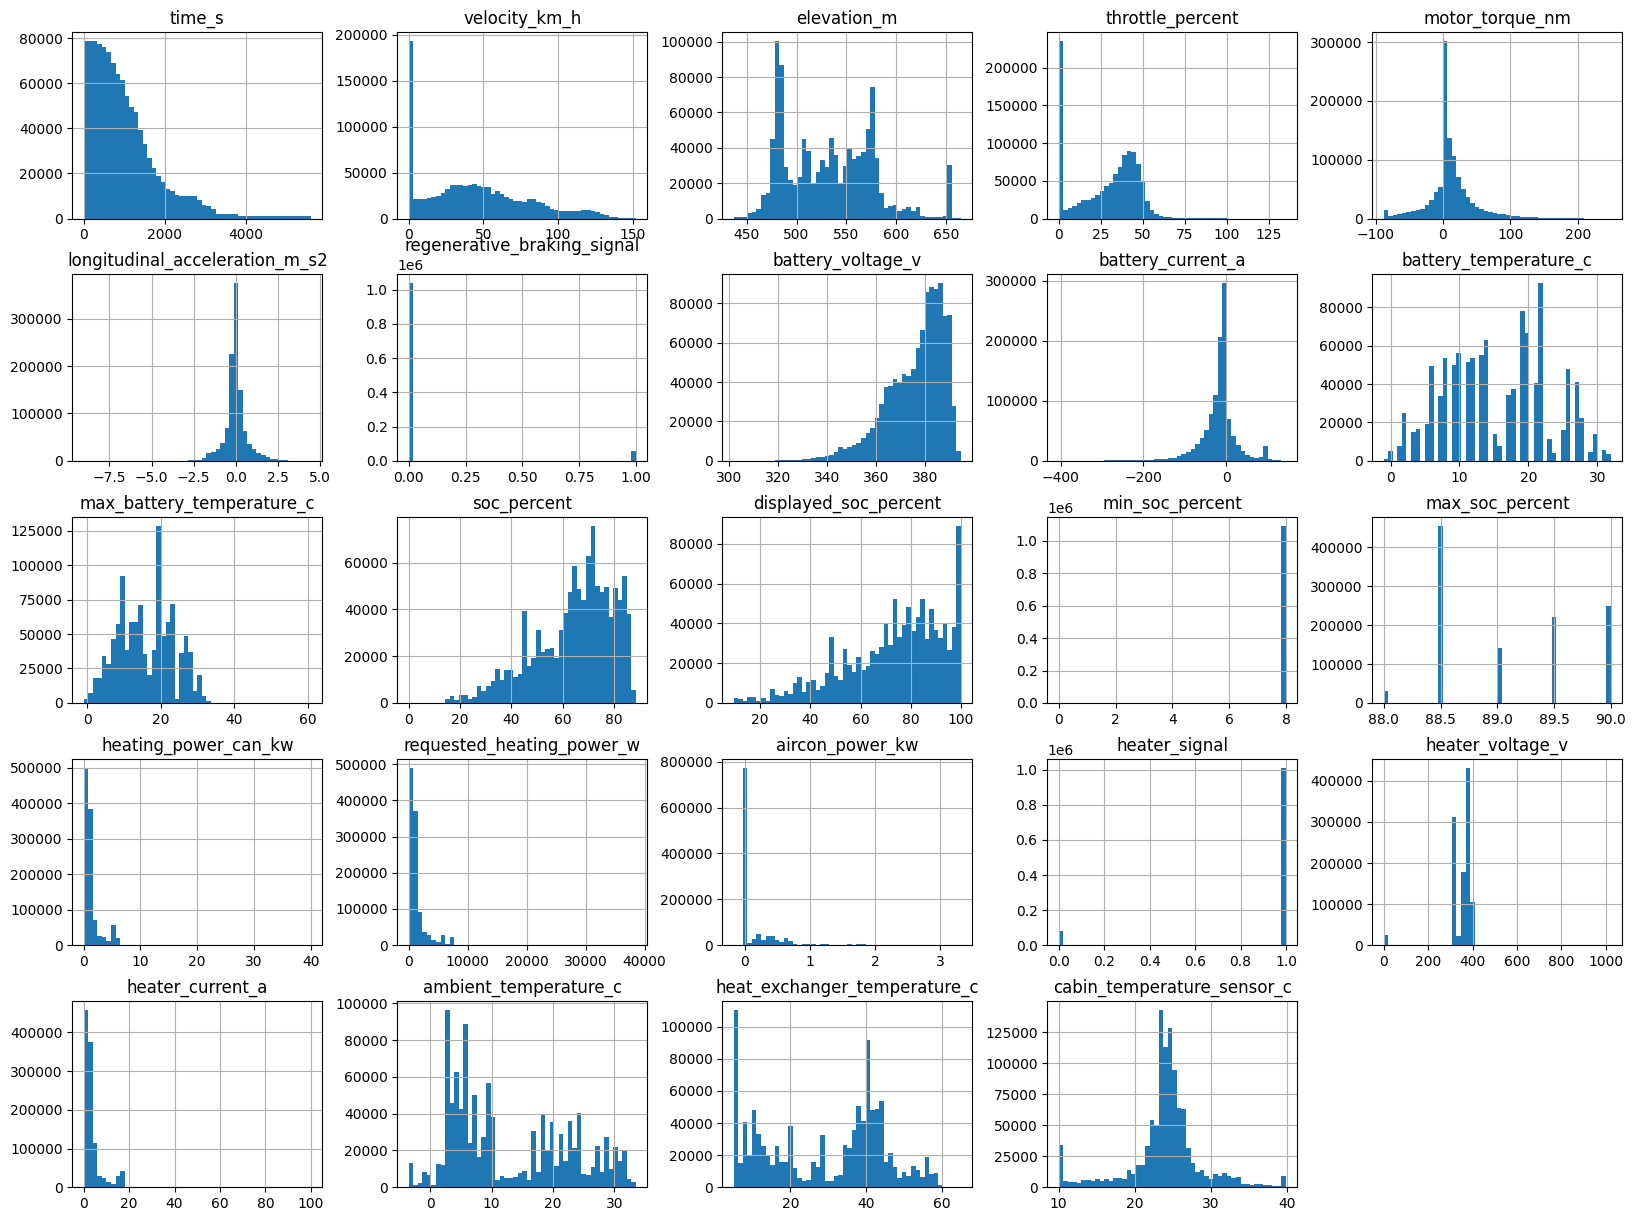

In [18]:
# Histogramme pour visualiser la distribution des variables numériques
df.hist(bins=50, figsize=(20,15))
plt.show()

Matrice de corrélation

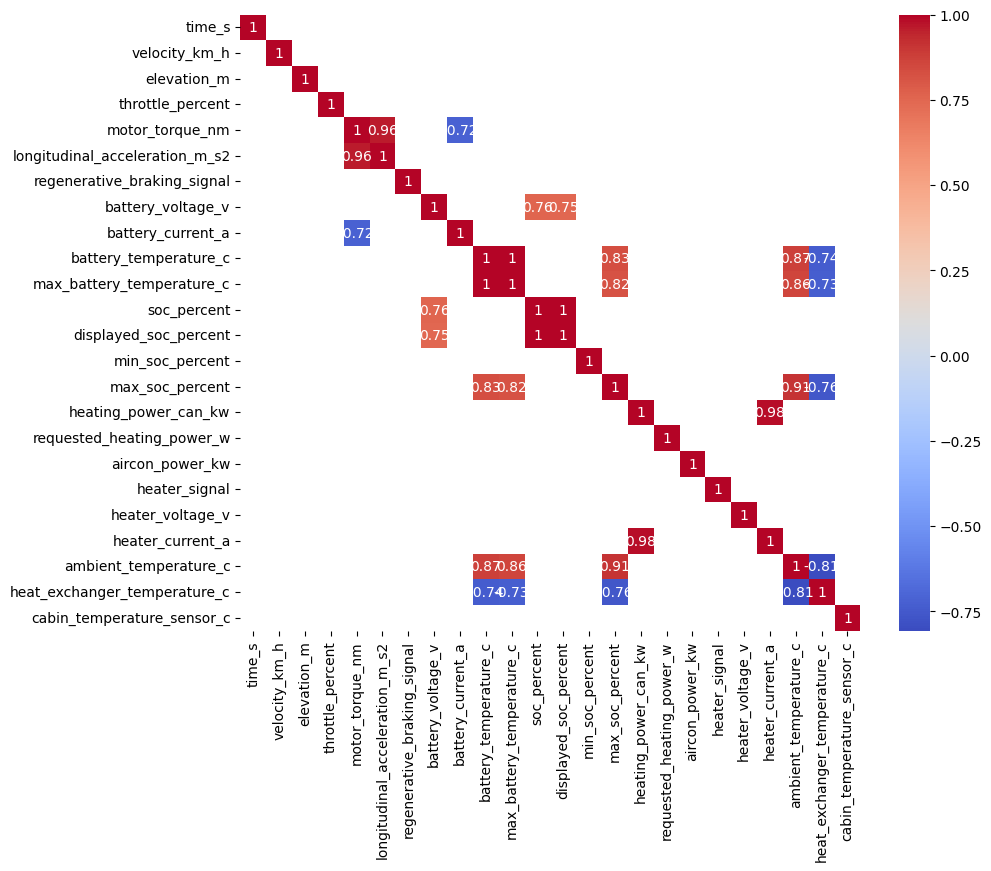

In [22]:
num_df = df.select_dtypes(include=[np.number])

corr = num_df.corr()

mask = np.abs(corr) < 0.7

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask = mask, annot=False, cmap='coolwarm')
plt.show()